In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow_io

In [3]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio


data_dir = "data"
audio_folder = "audio"
noise_folder = "noise"
drive_path = "/content/drive/MyDrive/"

In [4]:
audio_path = os.path.join(drive_path, data_dir, audio_folder)
noise_path = os.path.join(drive_path, data_dir, noise_folder)

voice_file_names = os.listdir(audio_path)
noise_file_names = os.listdir(noise_path)

In [5]:
#tests

audio_file_test = os.path.join(audio_path, "dasun", "1.wav")
noise_file_test = os.path.join(noise_path, "background", "adult-male-coughing-45593.wav")
print(audio_file_test)
print(noise_file_test)

/content/drive/MyDrive/data/audio/dasun/1.wav
/content/drive/MyDrive/data/noise/background/adult-male-coughing-45593.wav


In [6]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [7]:
wave = load_wav_16k_mono(audio_file_test)
nwave = load_wav_16k_mono(noise_file_test)

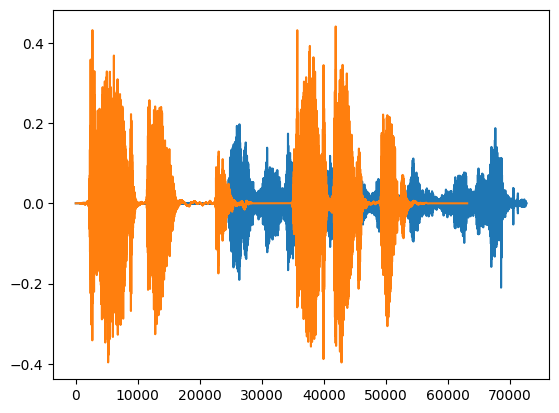

In [8]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [9]:
POS = os.path.join(audio_path, "dasun")
NEG = os.path.join(noise_path, "background")

In [10]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [11]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [12]:
lengths = []
for file in os.listdir(os.path.join(audio_path, "dasun")):
    tensor_wave = load_wav_16k_mono(os.path.join(audio_path, "dasun", file))
    lengths.append(len(tensor_wave))

In [13]:
lengthx = []
for file in os.listdir(os.path.join(noise_path, "background")):
    tensor_wave = load_wav_16k_mono(os.path.join(noise_path, "background", file))
    lengthx.append(len(tensor_wave))

In [14]:
lengths

[72704, 72704]

In [15]:
tf.math.reduce_mean(lengthx)

<tf.Tensor: shape=(), dtype=int32, numpy=419295>

In [16]:
tf.math.reduce_min(lengthx)

<tf.Tensor: shape=(), dtype=int32, numpy=30336>

In [17]:
tf.math.reduce_max(lengthx)

<tf.Tensor: shape=(), dtype=int32, numpy=2184960>

In [18]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [19]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [20]:
label

1.0

In [21]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [22]:
label

0.0

In [23]:
spectrogram, label = preprocess(filepath, label)

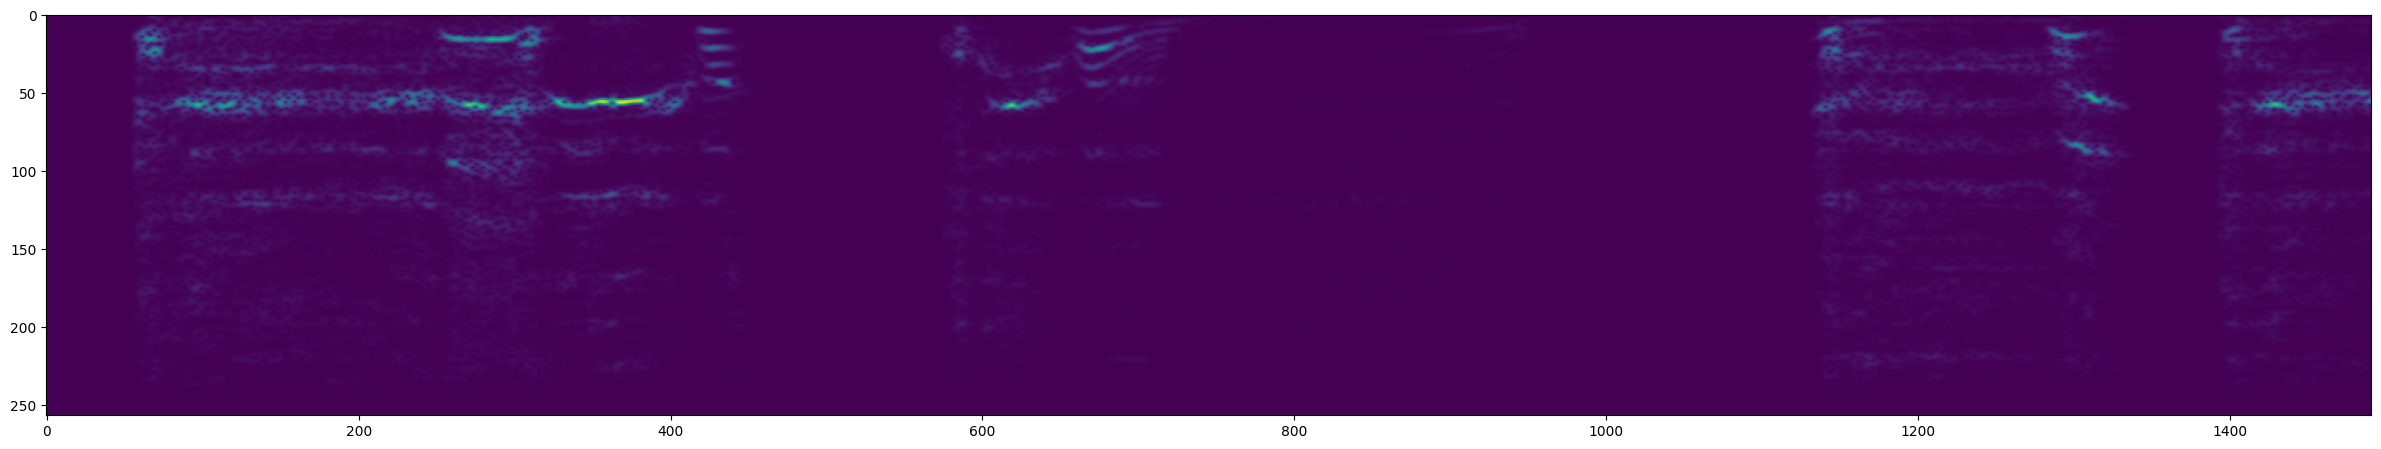

In [24]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [25]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [26]:
samples, labels = data.as_numpy_iterator().next()

In [27]:
samples

array([[[[7.12021574e-05],
         [5.99889718e-05],
         [3.27317357e-05],
         ...,
         [3.49869936e-07],
         [1.86947389e-07],
         [2.26664270e-07]],

        [[1.58095936e-04],
         [1.25080609e-04],
         [6.18234844e-05],
         ...,
         [5.51403438e-08],
         [1.63622957e-07],
         [1.00211764e-07]],

        [[3.42647632e-04],
         [2.91291391e-04],
         [2.00693248e-04],
         ...,
         [2.40002180e-07],
         [9.56317692e-08],
         [7.58736860e-08]],

        ...,

        [[5.95454335e-01],
         [5.34865499e-01],
         [4.05546188e-01],
         ...,
         [9.98404576e-05],
         [7.18939045e-05],
         [8.58604908e-05]],

        [[6.08440399e-01],
         [5.20710528e-01],
         [3.42539042e-01],
         ...,
         [1.65203237e-04],
         [2.91260531e-05],
         [9.87052917e-05]],

        [[5.15385628e-01],
         [4.55885231e-01],
         [2.52400517e-01],
         ...,
 

In [28]:
labels

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [29]:
# not enough data hence redundant code

train = data.take(36)
test = data.skip(36).take(15)

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [31]:
for spectrogram, _ in data.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(labels)

Input shape: (14, 1491, 257, 1)


In [32]:
tf.shape(samples)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  14, 1491,  257,    1], dtype=int32)>

In [33]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 32)     320       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 32)     9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 1485, 251, 64)     18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 742, 125, 64)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5936000)           0         
                                                                 
 dense (Dense)               (None, 128)               759808128 
                                                        

In [35]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
